In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from models.MLP import MLP, plot_training

In [16]:
df_data = pd.read_csv('../data/train.csv')
df_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [17]:
X = df_data.iloc[:,2:].values
species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1

In [18]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

## Test d'entrainement via une descente de gradiant 

In [19]:
model = MLP(X_train, t_train, X_test, t_test, num_epochs=500)
model.set_model(input_size=X_train.shape[1], output_size=t_train.shape[1], activation_function='relu')
model.set_optimizer(optim='SGD', lr=1e-2, reg=0)

In [20]:
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

AttributeError: 'MLP' object has no attribute '_optimizer'

In [21]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 65.32% sur les données test


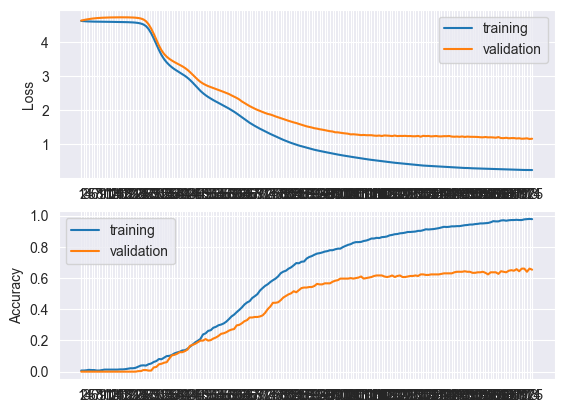

In [22]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

# Ajout d'un terme de régularisation

In [23]:
model.set_optimizer(optim='SGD', lr=1e-2, reg=1e-3)
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

AttributeError: 'MLP' object has no attribute '_optimizer'

In [ ]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

In [ ]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

## Recherche des hyperparamètres

In [ ]:
best_params, accuracy_historic = model.k_fold_cross_validation(X_train, t_train)

In [ ]:
best_params

### Apprentissage complet du modèle avec les meilleurs hyperparamètres trouvés

In [ ]:
model.set_optimizer(optim='SGD', lr=best_params[0], reg=best_params[1])
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

In [ ]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

In [ ]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

### Normalisation des données

In [24]:
df_data.iloc[:,2:].max()

margin1      0.087891
margin2      0.205080
margin3      0.156250
margin4      0.169920
margin5      0.111330
               ...   
texture60    0.578130
texture61    0.151370
texture62    0.375980
texture63    0.086914
texture64    0.141600
Length: 192, dtype: float64

Les données ne sont pas normalisées ce qui peut donner injustement plus de poids à certaines caractéristiques plutôt qu'à d'autre. Pour palier ce problème nous normalison nos données selon la normalisation min-max.

In [25]:
X = ((df_data.iloc[:,2:] - df_data.iloc[:,2:].min()) / (df_data.iloc[:,2:].max() - df_data.iloc[:,2:].min())).values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1
    
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [29]:
model.set_optimizer(optim='SGD', lr=1e-3, reg=1e-4)
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

Epoch 1/500, Loss: 4.59578, Accuracy: 1.01%
Epoch 2/500, Loss: 4.59537, Accuracy: 0.87%
Epoch 3/500, Loss: 4.59496, Accuracy: 0.87%
Epoch 4/500, Loss: 4.59456, Accuracy: 0.87%
Epoch 5/500, Loss: 4.59416, Accuracy: 0.87%
Epoch 6/500, Loss: 4.59375, Accuracy: 1.01%
Epoch 7/500, Loss: 4.59335, Accuracy: 1.01%
Epoch 8/500, Loss: 4.59294, Accuracy: 1.01%
Epoch 9/500, Loss: 4.59252, Accuracy: 1.01%
Epoch 10/500, Loss: 4.59211, Accuracy: 1.30%
Epoch 11/500, Loss: 4.59170, Accuracy: 1.30%
Epoch 12/500, Loss: 4.59129, Accuracy: 1.44%
Epoch 13/500, Loss: 4.59088, Accuracy: 1.73%
Epoch 14/500, Loss: 4.59046, Accuracy: 1.73%
Epoch 15/500, Loss: 4.59005, Accuracy: 1.88%
Epoch 16/500, Loss: 4.58963, Accuracy: 1.88%
Epoch 17/500, Loss: 4.58920, Accuracy: 1.88%
Epoch 18/500, Loss: 4.58876, Accuracy: 2.02%
Epoch 19/500, Loss: 4.58831, Accuracy: 2.16%
Epoch 20/500, Loss: 4.58786, Accuracy: 2.16%


KeyboardInterrupt: 

In [27]:
print("Précision du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Précision du model de 65.32% sur les données test


Les performances du modèle sont grandement améliorées en normalisant les données.

In [28]:
best_params, accuracy_historic = model.k_fold_cross_validation(X_train, t_train)

testing parameters: learning_rate = 1e-04,    regularization = 1e-03


KeyboardInterrupt: 

In [ ]:
ax = sns.heatmap(accuracy_historic[:-1], linewidths=0.5, cmap='gist_heat', xticklabels=reg_choices, yticklabels=lr_choices)

In [ ]:
best_params

### Apprentissage global avec les meilleurs hyperparamètres

In [ ]:
model.set_optimizer(optim='SGD', lr=best_params[0], reg=best_params[1])
loss_train, accuracy_train, loss_test, accuracy_test = model.training(X_train, t_train, X_test, t_test)

In [ ]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

In [ ]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)